In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import graphviz
import seaborn as sns
import math

pd.set_option('display.max_columns', 500)

In [2]:
data = pd.read_excel('./melbourne-house-prices/melbourne-house-prices.xlsx')

In [3]:
data.head()

,suburb,address,rooms,type_code,type,min_bound_100K,max_bound_100K,price_bands,method_orig,method,realestate_agent,date,year,month,day,distance,postcode,bedrooms,bathrooms,car_parks,landsize,building_area,year_built,council_area,lattitude,longtitude,region_name,suburb_property_count
0,Footscray,202/51 Gordon St,1,u,unit,0K,100K,0K-100K,PI,PI,Burnham,2016-09-03,2016,9,3,6.4,3011,1.0,1.0,0.0,0.0,NaN,2007.0,Maribyrnong City Council,-37.7911,144.8900,Western Metropolitan,7570
1,Malvern East,114/141 Waverley Rd,1,u,unit,100K,200K,100K-200K,S,S,C21,2018-01-06,2018,1,6,8.4,3145,NaN,NaN,NaN,NaN,NaN,NaN,Stonnington City Council,NaN,NaN,Southern Metropolitan,8801
2,East Melbourne,515/133 Jolimont Rd,1,u,unit,100K,200K,100K-200K,PI,PI,Dixon,2017-07-08,2017,7,8,1.3,3002,NaN,NaN,NaN,NaN,NaN,NaN,Melbourne City Council,NaN,NaN,Northern Metropolitan,3040
3,Caulfield,30 Pyne St,4,h,house,100K,200K,100K-200K,PI,PI,Rodney,2017-02-25,2017,2,25,8.9,3162,4.0,1.0,2.0,499.0,155.0,1920.0,Glen Eira City Council,-37.8864,145.0242,Southern Metropolitan,2379
4,Coburg,171 Moreland Rd,4,h,house,100K,200K,100K-200K,PI,PI,Jellis,2016-06-04,2016,6,4,7.8,3058,3.0,1.0,1.0,536.0,164.0,1910.0,Darebin City Council,-37.7555,144.9658,Northern Metropolitan,11204


In [4]:
data.dtypes

suburb                           object
address                          object
rooms                             int64
type_code                        object
type                             object
min_bound_100K                   object
max_bound_100K                   object
price_bands                      object
method_orig                      object
method                           object
realestate_agent                 object
date                     datetime64[ns]
year                              int64
month                             int64
day                               int64
distance                        float64
postcode                          int64
bedrooms                        float64
bathrooms                       float64
car_parks                       float64
landsize                        float64
building_area                   float64
year_built                      float64
council_area                     object
lattitude                       float64


In [5]:
data.shape

(27244, 28)

In [6]:
data.select_dtypes(exclude=[np.number]).columns.tolist()

[u'suburb',
 u'address',
 u'type_code',
 u'type',
 u'min_bound_100K',
 u'max_bound_100K',
 u'price_bands',
 u'method_orig',
 u'method',
 u'realestate_agent',
 u'date',
 u'council_area',
 u'region_name']

In [7]:
### create a copy of the dataframe so the original dataframe doesn't change
data_copy = data.copy()

## change the type of the max_bound_100K column to integer, so it's easier to explore the dataset
for i, row in data_copy.iterrows():
    max_bound = data_copy.at[i,'max_bound_100K']
    max_bound_int = int(max_bound[:-1])
    data_copy.at[i,'max_bound_100K'] = max_bound_int

data_copy["max_bound_100K"] = pd.to_numeric(data_copy["max_bound_100K"])

## compare method_orig and method, if they are too similar, then drop one of them
count = 0
for i, row in data_copy.iterrows():
    method_orig = data_copy.at[i,'method_orig']
    method = data_copy.at[i, 'method']
    
    if (method_orig == method):
        count += 1

print(count)

### drop redundant columns
data_copy = data_copy.drop(columns=['date', 'day', 'month', 'type', 'min_bound_100K', 'address'])

24561


shape of dataframe: 
(27244, 22)


histogram


<Figure size 432x288 with 0 Axes>

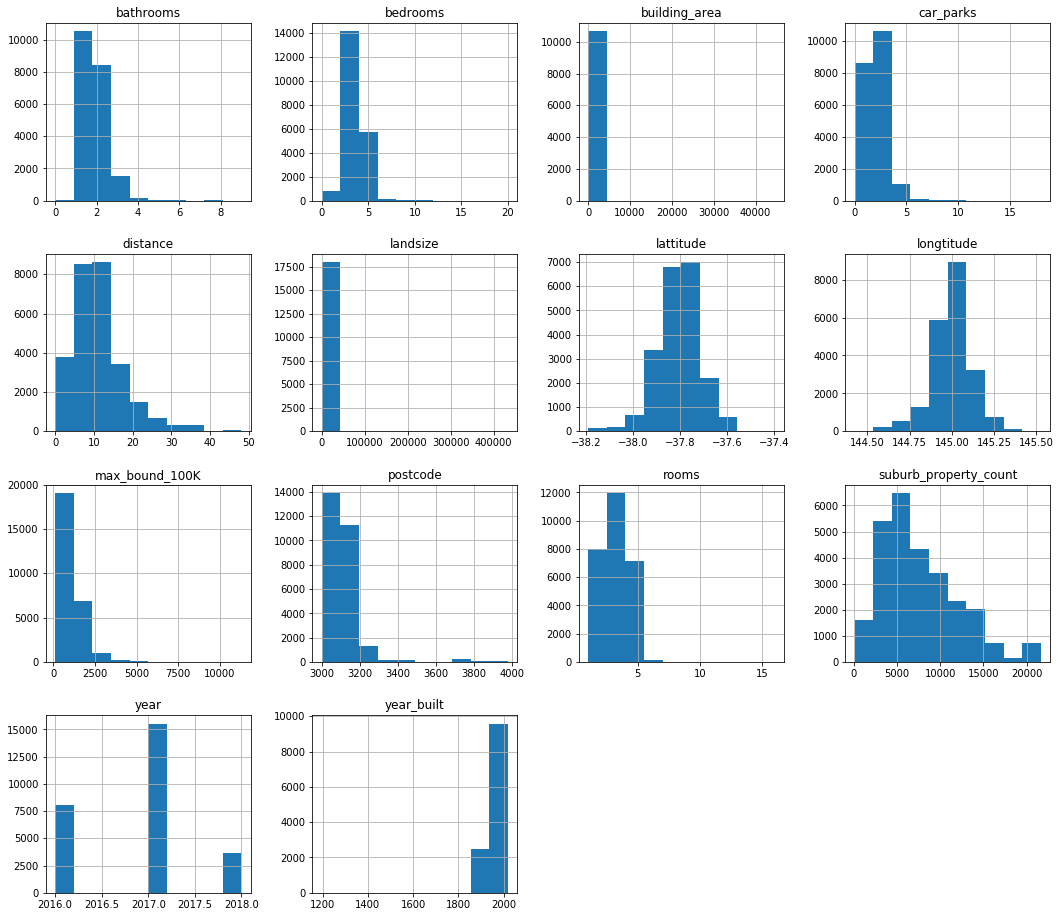

In [8]:
### data exploration
print("shape of dataframe: ")
print(data_copy.shape)
print("\n")

print("histogram")
plt.figure()
data_copy.hist(figsize=(18, 16))
plt.show()

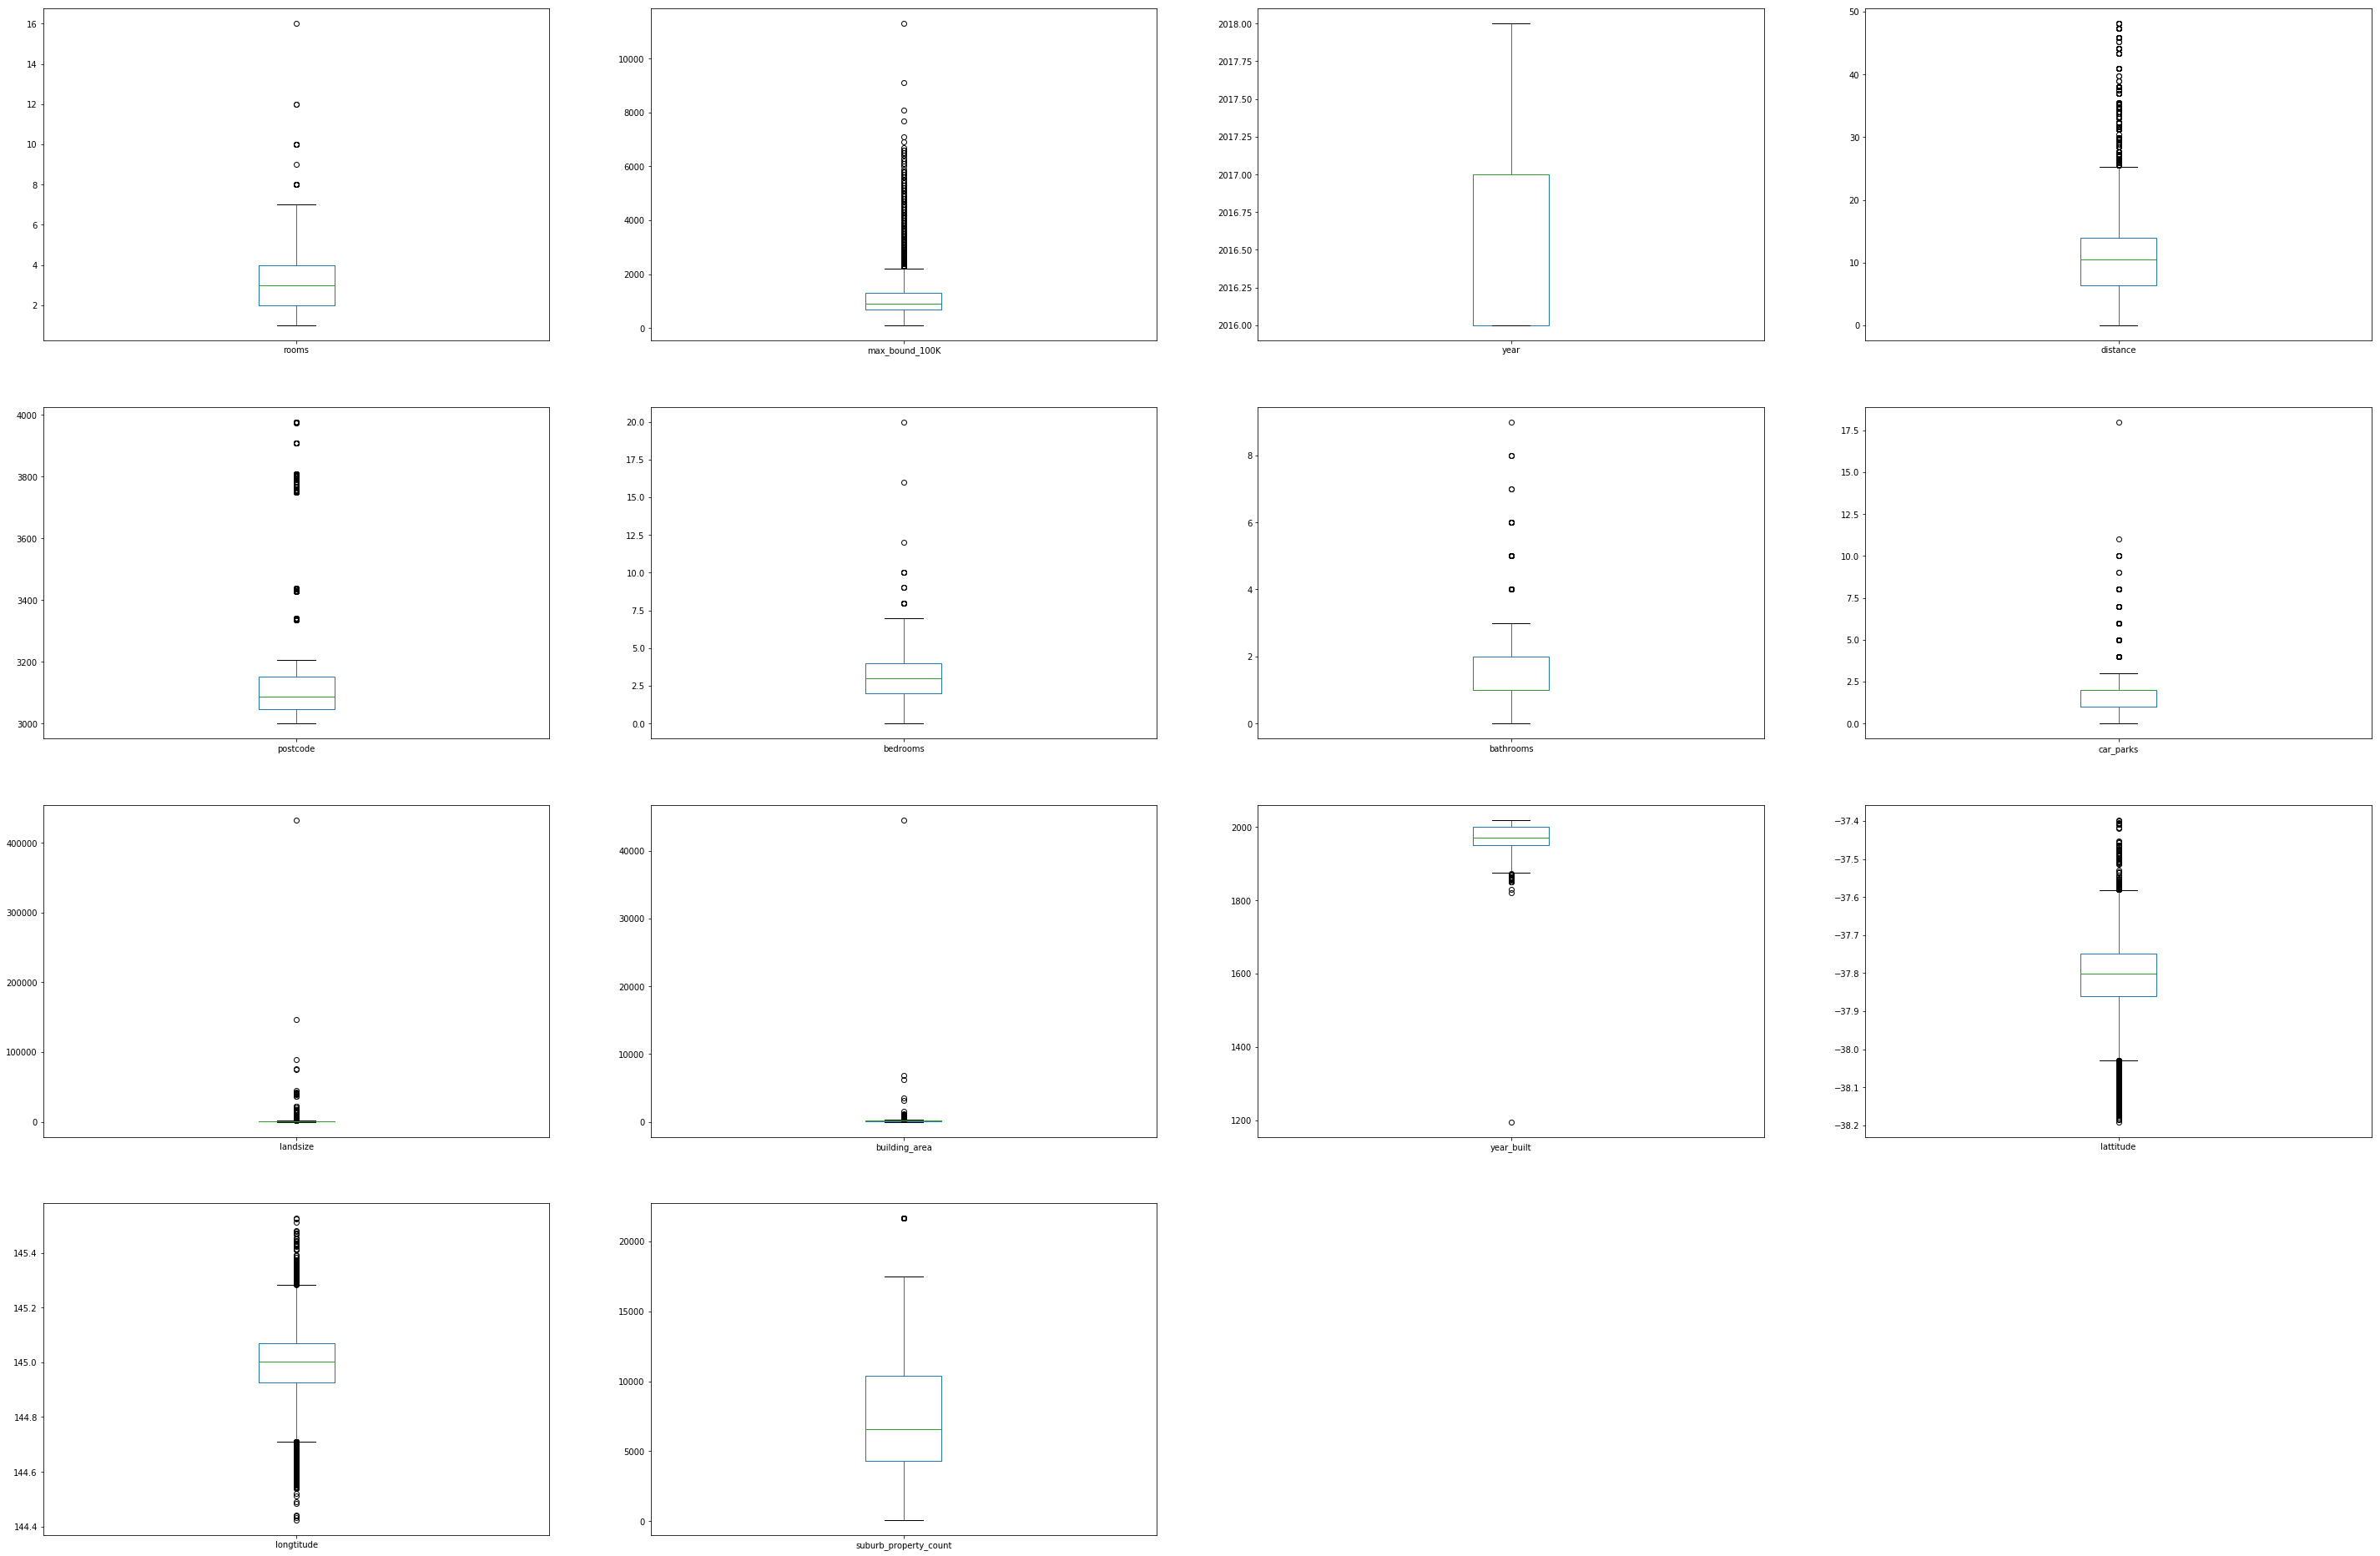

In [9]:
data_copy.plot(kind='box', figsize=(50, 60), subplots=True, layout=(7,4), sharex=False,
sharey=False)
plt.show()

,rooms,max_bound_100K,year,distance,postcode,bedrooms,bathrooms,car_parks,landsize,building_area,year_built,lattitude,longtitude,suburb_property_count
rooms,1.000000,0.465202,0.088637,0.284260,0.081301,0.958741,0.607968,0.394828,0.034255,0.138519,-0.001638,0.020936,0.087130,-0.079572
max_bound_100K,0.465202,1.000000,-0.020685,-0.211599,0.045209,0.430247,0.429844,0.201819,0.032950,0.100398,-0.333337,-0.215171,0.197764,-0.059098
year,0.088637,-0.020685,1.000000,0.230431,0.103356,0.192564,0.096418,0.143054,0.024231,0.021413,0.100298,0.037391,0.036365,0.009970
distance,0.284260,-0.211599,0.230431,1.000000,0.489722,0.282813,0.140767,0.244177,0.055257,0.076786,0.314522,-0.089573,0.188951,-0.021705
postcode,0.081301,0.045209,0.103356,0.489722,1.000000,0.087748,0.123822,0.062870,0.037747,0.041697,0.097365,-0.218780,0.364808,0.023217
bedrooms,0.958741,0.430247,0.192564,0.282813,0.087748,1.000000,0.605309,0.396458,0.034167,0.136956,0.007896,0.019087,0.090658,-0.059863
bathrooms,0.607968,0.429844,0.096418,0.140767,0.123822,0.605309,1.000000,0.305628,0.037578,0.129216,0.185514,-0.047392,0.103547,-0.040319
car_parks,0.394828,0.201819,0.143054,0.244177,0.062870,0.396458,0.305628,1.000000,0.031301,0.094166,0.125057,0.002003,0.039071,-0.013955
landsize,0.034255,0.032950,0.024231,0.055257,0.037747,0.034167,0.037578,0.031301,1.000000,0.375341,0.040782,0.023689,-0.003633,-0.016988
building_area,0.138519,0.100398,0.021413,0.076786,0.041697,0.136956,0.129216,0.094166,0.375341,1.000000,0.072976,0.025880,-0.010702,-0.026473


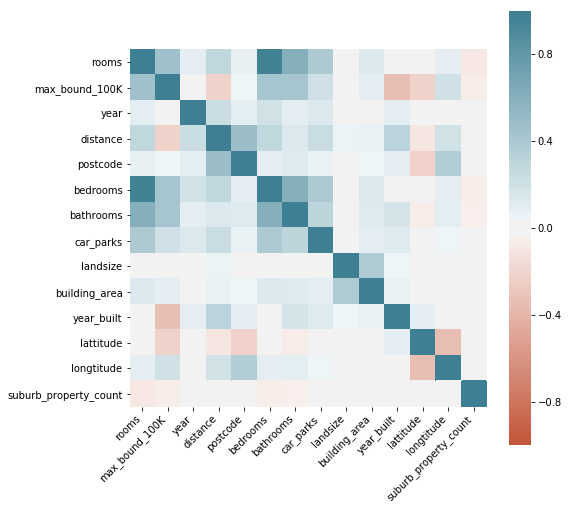

In [10]:
## correlation matrix
corr = data_copy.corr()
plt.figure(figsize = (8,8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
# data_copy.dtypes
# data_copy.head()
data_copy.corr()

In [11]:
### check for missing values
# count the number of missing values in each column
data_copy.isnull().sum()

suburb                       0
rooms                        0
type_code                    0
max_bound_100K               0
price_bands                  0
method_orig                  0
method                       0
realestate_agent             0
year                         0
distance                     0
postcode                     0
bedrooms                  6438
bathrooms                 6444
car_parks                 6821
landsize                  9262
building_area            16588
year_built               15160
council_area                 0
lattitude                 6251
longtitude                6251
region_name                  0
suburb_property_count        0
dtype: int64

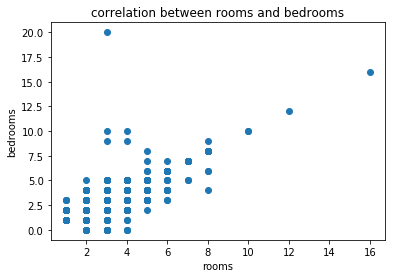

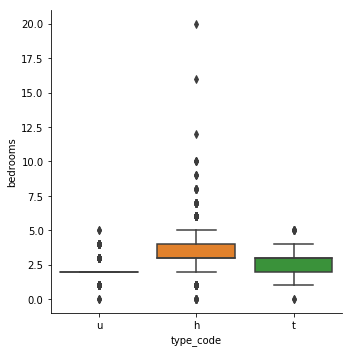

suburb                       0
rooms                        0
type_code                    0
max_bound_100K               0
price_bands                  0
method_orig                  0
method                       0
realestate_agent             0
year                         0
distance                     0
postcode                     0
bedrooms                     1
bathrooms                 6444
car_parks                 6821
landsize                  9262
building_area            16588
year_built               15160
council_area                 0
lattitude                 6251
longtitude                6251
region_name                  0
suburb_property_count        0
dtype: int64

In [12]:
### Analyze how to handle missing values for bedroom column

## based on the correlation matrix, bedrooms has very strong linear relationship with rooms
## the scatter plot also shows a strong linear relationship
x = data_copy['rooms']
y = data_copy['bedrooms']
plt.scatter(x, y)
plt.title('correlation between rooms and bedrooms')
plt.xlabel('rooms')
plt.ylabel('bedrooms')
plt.show()

## the correlation between rooms and bedrooms is as high as 0.958741

# bedroom boxplot by type
sns.catplot(x="type_code", y="bedrooms", kind="box", data=data_copy);
plt.show()

## group by type and rooms, then calculate the bedroom median for each group
bedroomAgg = data_copy.groupby(['type_code', 'rooms'])['bedrooms'].median().to_frame().reset_index()
# bathroomAgg
# print(bathroomAgg)

## impute corresponding bathroom median
for i, row in data_copy.iterrows():
    houseType = data_copy.at[i, 'type_code']
    rooms = data_copy.at[i, 'rooms']
    bedrooms = data_copy.at[i, 'bedrooms']
  
    if (math.isnan(bedrooms)):
        imputedValue = bedroomAgg.loc[(bedroomAgg['type_code'] == houseType) & (bedroomAgg['rooms'] == rooms)]['bedrooms']
        data_copy.at[i, 'bedrooms'] = imputedValue
    
data_copy.isnull().sum()

In [13]:
## only one example has 9 rooms, but this example contains too many missing values. So it's removed
data_copy = data_copy.drop(data_copy[data_copy.rooms == 9].index)

In [14]:
### handle missing values in the bathrooms column
data_copy.isnull().sum()

bathrooms = data_copy.loc[data_copy['bathrooms'].isnull()]
print(bathrooms.shape)
bathrooms.isnull().sum()

(6443, 22)


suburb                      0
rooms                       0
type_code                   0
max_bound_100K              0
price_bands                 0
method_orig                 0
method                      0
realestate_agent            0
year                        0
distance                    0
postcode                    0
bedrooms                    0
bathrooms                6443
car_parks                6443
landsize                 6434
building_area            6443
year_built               6442
council_area                0
lattitude                6228
longtitude               6228
region_name                 0
suburb_property_count       0
dtype: int64

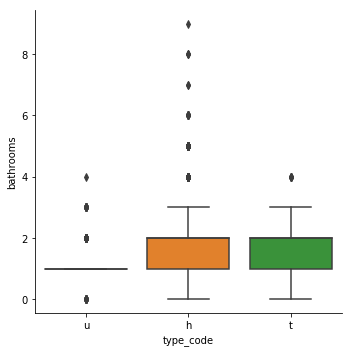

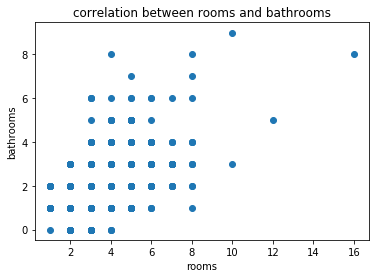

In [15]:
# bathroom boxplot by type
sns.catplot(x="type_code", y="bathrooms", kind="box", data=data_copy);
plt.show()

x = data_copy['rooms']
y = data_copy['bathrooms']
plt.scatter(x, y)
plt.title('correlation between rooms and bathrooms')
plt.xlabel('rooms')
plt.ylabel('bathrooms')
plt.show()

In [16]:
## group by type and rooms, then calculate the median for each group
bathroomAgg = data_copy.groupby(['type_code', 'rooms'])['bathrooms'].median().to_frame().reset_index()
# bathroomAgg
# print(bathroomAgg)

## impute corresponding bathroom median
for i, row in data_copy.iterrows():
    houseType = data_copy.at[i, 'type_code']
    rooms = data_copy.at[i, 'rooms']
    bathrooms = data_copy.at[i, 'bathrooms']
  
    if (math.isnan(bathrooms)):
        imputedValue = bathroomAgg.loc[(bathroomAgg['type_code'] == houseType) & (bathroomAgg['rooms'] == rooms)]['bathrooms']
        data_copy.at[i, 'bathrooms'] = imputedValue
    
data_copy.isnull().sum()

suburb                       0
rooms                        0
type_code                    0
max_bound_100K               0
price_bands                  0
method_orig                  0
method                       0
realestate_agent             0
year                         0
distance                     0
postcode                     0
bedrooms                     0
bathrooms                    0
car_parks                 6820
landsize                  9261
building_area            16587
year_built               15159
council_area                 0
lattitude                 6250
longtitude                6250
region_name                  0
suburb_property_count        0
dtype: int64

In [17]:
data_copy.isnull().sum()

suburb                       0
rooms                        0
type_code                    0
max_bound_100K               0
price_bands                  0
method_orig                  0
method                       0
realestate_agent             0
year                         0
distance                     0
postcode                     0
bedrooms                     0
bathrooms                    0
car_parks                 6820
landsize                  9261
building_area            16587
year_built               15159
council_area                 0
lattitude                 6250
longtitude                6250
region_name                  0
suburb_property_count        0
dtype: int64

(27243, 22)


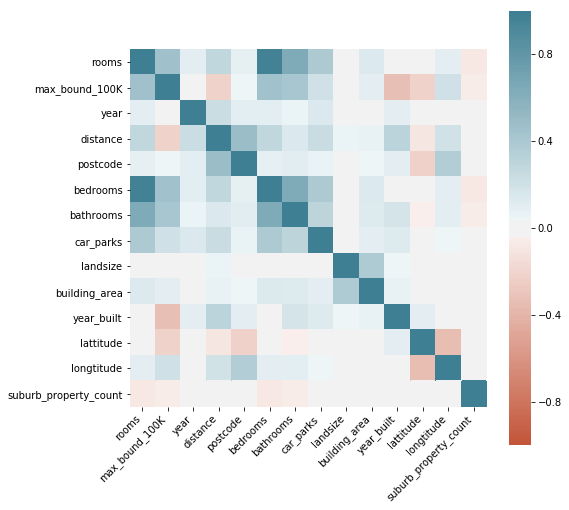

In [18]:
## correlation matrix
corr = data_copy.corr()
plt.figure(figsize = (8,8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
# data_copy.dtypes
# data_copy.head()
data_copy.corr()

print(data_copy.shape)

In [19]:
### car parks
missing_car_parks = data_copy.loc[data_copy['car_parks'].isnull()]
print(missing_car_parks.shape)
missing_car_parks.isnull().sum()

(6820, 22)


suburb                      0
rooms                       0
type_code                   0
max_bound_100K              0
price_bands                 0
method_orig                 0
method                      0
realestate_agent            0
year                        0
distance                    0
postcode                    0
bedrooms                    0
bathrooms                   0
car_parks                6820
landsize                 6539
building_area            6643
year_built               6624
council_area                0
lattitude                6228
longtitude               6228
region_name                 0
suburb_property_count       0
dtype: int64

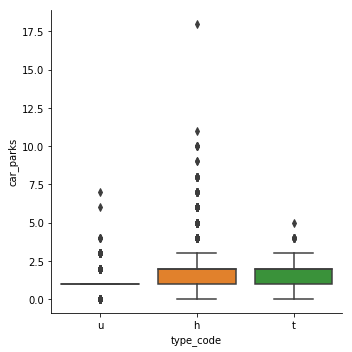

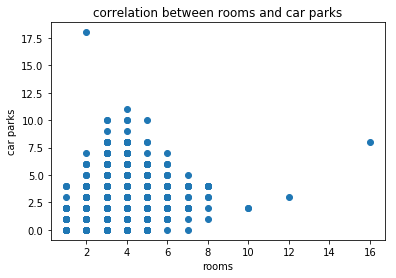

In [20]:
sns.catplot(x="type_code", y="car_parks", kind="box", data=data_copy);
plt.show()

x = data_copy['rooms']
y = data_copy['car_parks']
plt.scatter(x, y)
plt.title('correlation between rooms and car parks')
plt.xlabel('rooms')
plt.ylabel('car parks')
plt.show()

In [21]:
## group by type and rooms, then calculate the median for each group
carparkAgg = data_copy.groupby(['type_code', 'rooms'])['car_parks'].median().to_frame().reset_index()

## impute corresponding car park median
for i, row in data_copy.iterrows():
    houseType = data_copy.at[i, 'type_code']
    rooms = data_copy.at[i, 'rooms']
    car_parks = data_copy.at[i, 'car_parks']
  
    if (math.isnan(car_parks)):
        imputedValue = carparkAgg.loc[(carparkAgg['type_code'] == houseType) & (carparkAgg['rooms'] == rooms)]['car_parks']
        data_copy.at[i, 'car_parks'] = imputedValue
    
data_copy.isnull().sum()

suburb                       0
rooms                        0
type_code                    0
max_bound_100K               0
price_bands                  0
method_orig                  0
method                       0
realestate_agent             0
year                         0
distance                     0
postcode                     0
bedrooms                     0
bathrooms                    0
car_parks                    0
landsize                  9261
building_area            16587
year_built               15159
council_area                 0
lattitude                 6250
longtitude                6250
region_name                  0
suburb_property_count        0
dtype: int64

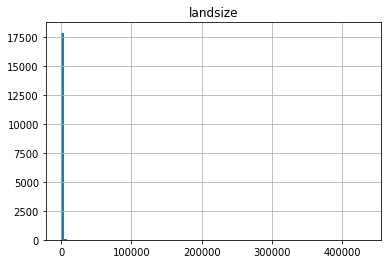

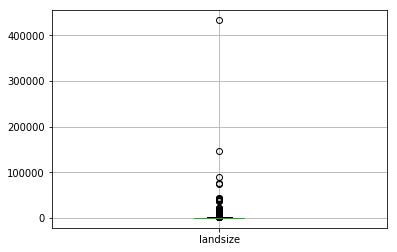

5
after removing outliers


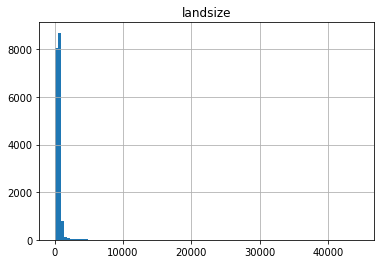

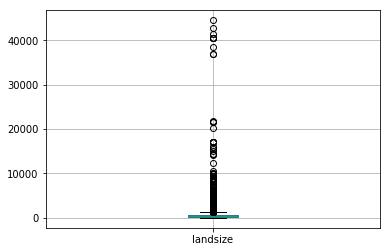

In [22]:
### handle missing landsize values

## quite a few outliers spotted
data_copy.hist(column=['landsize'], bins=100)
plt.show()

data_copy.boxplot(column=['landsize'])
plt.show()

print(data_copy.loc[data_copy['landsize'] > 50000].shape[0])

## remove outliers

data_copy = data_copy.drop(data_copy[data_copy.landsize > 50000].index)

print("after removing outliers")

data_copy.hist(column=['landsize'], bins=100)
plt.show()

data_copy.boxplot(column=['landsize'])
plt.show()

(17977, 22)
(17809, 22)


,rooms,max_bound_100K,year,distance,postcode,bedrooms,bathrooms,car_parks,landsize,building_area,year_built,lattitude,longtitude,suburb_property_count
rooms,1.000000,0.446628,0.184332,0.281085,0.081623,0.952148,0.600955,0.389207,0.375662,0.394732,-0.002661,0.014748,0.093953,-0.061335
max_bound_100K,0.446628,1.000000,0.033097,-0.231324,0.053254,0.429832,0.433437,0.198206,0.237500,0.322598,-0.329950,-0.225405,0.201883,-0.048052
year,0.184332,0.033097,1.000000,0.289669,0.116415,0.202111,0.095109,0.145276,0.194010,0.060485,0.087319,0.037608,0.040840,0.006159
distance,0.281085,-0.231324,0.289669,1.000000,0.482411,0.283943,0.131707,0.248352,0.329216,0.094892,0.317280,-0.090118,0.201227,0.002209
postcode,0.081623,0.053254,0.116415,0.482411,1.000000,0.085436,0.122841,0.058745,0.082619,0.059081,0.085472,-0.235029,0.374196,0.040073
bedrooms,0.952148,0.429832,0.202111,0.283943,0.085436,1.000000,0.597592,0.391176,0.368942,0.388305,0.007137,0.014593,0.096243,-0.061450
bathrooms,0.600955,0.433437,0.095109,0.131707,0.122841,0.597592,1.000000,0.299408,0.184627,0.366370,0.181002,-0.055976,0.108655,-0.042283
car_parks,0.389207,0.198206,0.145276,0.248352,0.058745,0.391176,0.299408,1.000000,0.312437,0.204805,0.128878,0.001982,0.043224,-0.013885
landsize,0.375662,0.237500,0.194010,0.329216,0.082619,0.368942,0.184627,0.312437,1.000000,0.228403,-0.020185,0.007886,0.140119,-0.044610
building_area,0.394732,0.322598,0.060485,0.094892,0.059081,0.388305,0.366370,0.204805,0.228403,1.000000,0.068363,-0.036682,0.072189,-0.042851


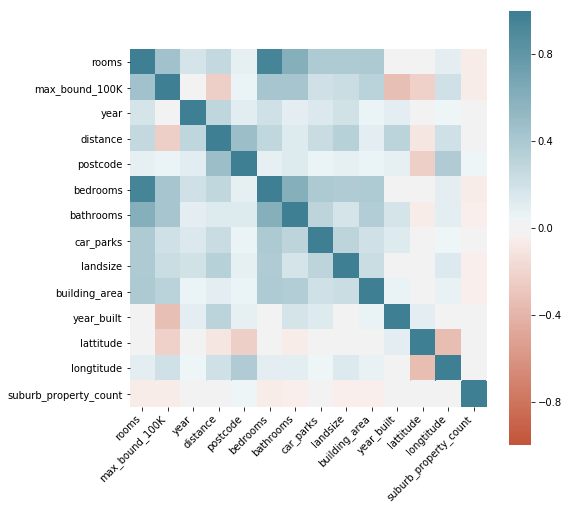

In [23]:
landsize = data_copy[data_copy['landsize'].notnull()]
print(landsize.shape)

normal_landsize = data_copy.loc[data_copy['landsize'] < 3000]
print(normal_landsize.shape)

## correlation matrix
corr = normal_landsize.corr()
plt.figure(figsize = (8,8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
# data_copy.dtypes
# data_copy.head()
normal_landsize.corr()

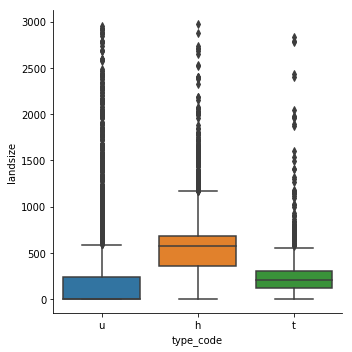

In [24]:
sns.catplot(x="type_code", y="landsize", kind="box", data=normal_landsize);
plt.show()

In [25]:
### impute missing values for house and town house
## group by type and rooms, then calculate the mean for each group
landsizeAgg = data_copy.groupby(['type_code', 'rooms'])['landsize'].median().to_frame().reset_index()

## impute corresponding land size mean
for i, row in data_copy.iterrows():
    houseType = data_copy.at[i, 'type_code']
    rooms = data_copy.at[i, 'rooms']
    land_size = data_copy.at[i, 'landsize']
  
    if (math.isnan(land_size)):
        imputedValue = landsizeAgg.loc[(landsizeAgg['type_code'] == houseType) & (landsizeAgg['rooms'] == rooms)]['landsize']
        data_copy.at[i, 'landsize'] = imputedValue

data_copy = data_copy[data_copy['landsize'].notnull()]

data_copy.isnull().sum()
data_copy.shape

(27237, 22)

In [26]:
data_copy.isnull().sum()

suburb                       0
rooms                        0
type_code                    0
max_bound_100K               0
price_bands                  0
method_orig                  0
method                       0
realestate_agent             0
year                         0
distance                     0
postcode                     0
bedrooms                     0
bathrooms                    0
car_parks                    0
landsize                     0
building_area            16581
year_built               15153
council_area                 0
lattitude                 6250
longtitude                6250
region_name                  0
suburb_property_count        0
dtype: int64

In [27]:
postcodeLattitude = data_copy.groupby(['postcode'])['lattitude'].mean().to_frame()
postcodeLongtitude = data_copy.groupby(['postcode'])['longtitude'].mean().to_frame()

## impute the lattitude and longtitude mean of each suburb
for i, row in data_copy.iterrows():
    suburb = data_copy.at[i,'postcode']
    lattitude = data_copy.at[i, 'lattitude']
    longtitude = data_copy.at[i, 'longtitude']
  
    if (math.isnan(lattitude)):
        imputedValue = postcodeLattitude.at[suburb, 'lattitude']
        data_copy.at[i, 'lattitude'] = imputedValue
    if (math.isnan(longtitude)):
        imputedValue = postcodeLongtitude.at[suburb, 'longtitude']
        data_copy.at[i, 'longtitude'] = imputedValue
        
data_copy.isnull().sum()

suburb                       0
rooms                        0
type_code                    0
max_bound_100K               0
price_bands                  0
method_orig                  0
method                       0
realestate_agent             0
year                         0
distance                     0
postcode                     0
bedrooms                     0
bathrooms                    0
car_parks                    0
landsize                     0
building_area            16581
year_built               15153
council_area                 0
lattitude                    1
longtitude                   1
region_name                  0
suburb_property_count        0
dtype: int64

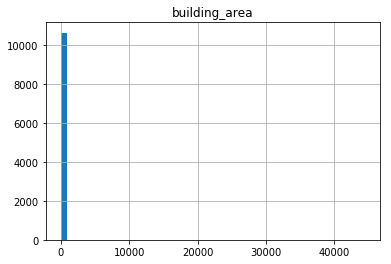

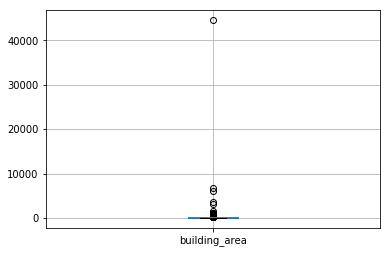

count: 
5
after removing outliers


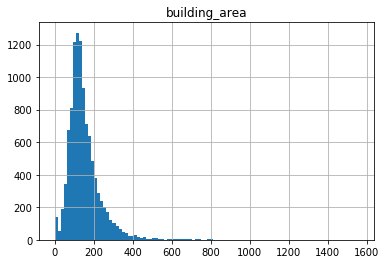

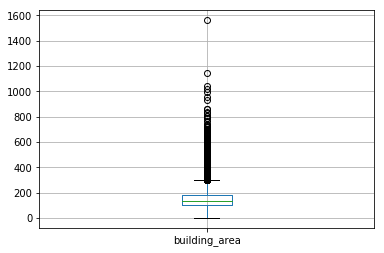

In [28]:
### building area
data_copy.hist(column=['building_area'], bins=50)
plt.show()

data_copy.boxplot(column=['building_area'])
plt.show()

dataBuildingArea = data_copy.loc[data_copy['building_area'] > 2000]
print("count: ")
print(dataBuildingArea.shape[0])

## remove outliers

data_copy = data_copy.drop(data_copy[data_copy.building_area > 2000].index)

print("after removing outliers")

data_copy.hist(column=['building_area'], bins=100)
plt.show()

data_copy.boxplot(column=['building_area'])
plt.show()

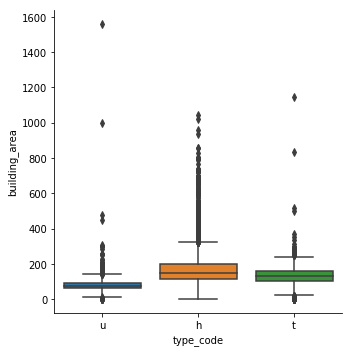

In [29]:
sns.catplot(x="type_code", y="building_area", kind="box", data=data_copy);
plt.show()

In [30]:
### impute missing values for house and town house
## group by type and rooms, then calculate the building area median for each group
landsizeAgg = data_copy.groupby(['type_code', 'rooms'])['building_area'].median().to_frame().reset_index()

## impute corresponding land size mean
for i, row in data_copy.iterrows():
    houseType = data_copy.at[i, 'type_code']
    rooms = data_copy.at[i, 'rooms']
    land_size = data_copy.at[i, 'building_area']
  
    if (math.isnan(land_size)):
        imputedValue = landsizeAgg.loc[(landsizeAgg['type_code'] == houseType) & (landsizeAgg['rooms'] == rooms)]['building_area']
        data_copy.at[i, 'building_area'] = imputedValue

data_copy.isnull().sum()
# data_copy.shape

suburb                       0
rooms                        0
type_code                    0
max_bound_100K               0
price_bands                  0
method_orig                  0
method                       0
realestate_agent             0
year                         0
distance                     0
postcode                     0
bedrooms                     0
bathrooms                    0
car_parks                    0
landsize                     0
building_area                2
year_built               15149
council_area                 0
lattitude                    1
longtitude                   1
region_name                  0
suburb_property_count        0
dtype: int64

In [31]:
data_copy = data_copy[data_copy['building_area'].notnull()]


In [32]:
# data_copy = data_copy.drop(columns=["year_built"])

In [33]:
missing_lattitude = data_copy.loc[data_copy['lattitude'].isnull()]
print(missing_lattitude)

data_copy.isnull().sum()

data_copy = data_copy[data_copy['lattitude'].notnull()]
data_copy.isnull().sum()

       suburb  rooms type_code  max_bound_100K price_bands method_orig method  \
13222  Tecoma      4         h             900   800K-900K          SP     SP   

      realestate_agent  year  distance  postcode  bedrooms  bathrooms  \
13222        Harcourts  2017      30.4      3160       4.0        2.0   

       car_parks  landsize  building_area  year_built  \
13222        2.0     621.0          190.0         NaN   

                     council_area  lattitude  longtitude       region_name  \
13222  Yarra Ranges Shire Council        NaN         NaN  Eastern Victoria   

       suburb_property_count  
13222                    869  


suburb                       0
rooms                        0
type_code                    0
max_bound_100K               0
price_bands                  0
method_orig                  0
method                       0
realestate_agent             0
year                         0
distance                     0
postcode                     0
bedrooms                     0
bathrooms                    0
car_parks                    0
landsize                     0
building_area                0
year_built               15146
council_area                 0
lattitude                    0
longtitude                   0
region_name                  0
suburb_property_count        0
dtype: int64

In [34]:
data_copy.isnull().sum()

suburb                       0
rooms                        0
type_code                    0
max_bound_100K               0
price_bands                  0
method_orig                  0
method                       0
realestate_agent             0
year                         0
distance                     0
postcode                     0
bedrooms                     0
bathrooms                    0
car_parks                    0
landsize                     0
building_area                0
year_built               15146
council_area                 0
lattitude                    0
longtitude                   0
region_name                  0
suburb_property_count        0
dtype: int64

In [35]:
### drop year built
data_copy = data_copy.drop(columns=['year_built'])

,rooms,max_bound_100K,year,distance,postcode,bedrooms,bathrooms,car_parks,landsize,building_area,lattitude,longtitude,suburb_property_count
rooms,1.000000,0.463903,0.089446,0.285114,0.081234,0.969005,0.644896,0.439429,0.151625,0.745272,0.023818,0.081318,-0.079284
max_bound_100K,0.463903,1.000000,-0.020456,-0.212101,0.045374,0.452199,0.424980,0.229168,0.086682,0.469274,-0.207337,0.194270,-0.059028
year,0.089446,-0.020456,1.000000,0.230536,0.103301,0.103520,0.059761,0.086769,0.034503,0.049145,0.023354,0.040513,0.010034
distance,0.285114,-0.212101,0.230536,1.000000,0.488763,0.287155,0.146233,0.245327,0.131156,0.201739,-0.099083,0.193880,-0.020632
postcode,0.081234,0.045374,0.103301,0.488763,1.000000,0.083952,0.110013,0.061746,0.059697,0.078429,-0.235011,0.369012,0.024162
bedrooms,0.969005,0.452199,0.103520,0.287155,0.083952,1.000000,0.642320,0.440697,0.149850,0.726843,0.023734,0.083421,-0.078900
bathrooms,0.644896,0.424980,0.059761,0.146233,0.110013,0.642320,1.000000,0.322728,0.097346,0.594081,-0.040556,0.098428,-0.052581
car_parks,0.439429,0.229168,0.086769,0.245327,0.061746,0.440697,0.322728,1.000000,0.144052,0.367464,0.010537,0.033743,-0.031114
landsize,0.151625,0.086682,0.034503,0.131156,0.059697,0.149850,0.097346,0.144052,1.000000,0.126361,0.036247,0.010503,-0.026649
building_area,0.745272,0.469274,0.049145,0.201739,0.078429,0.726843,0.594081,0.367464,0.126361,1.000000,-0.005258,0.080449,-0.065010


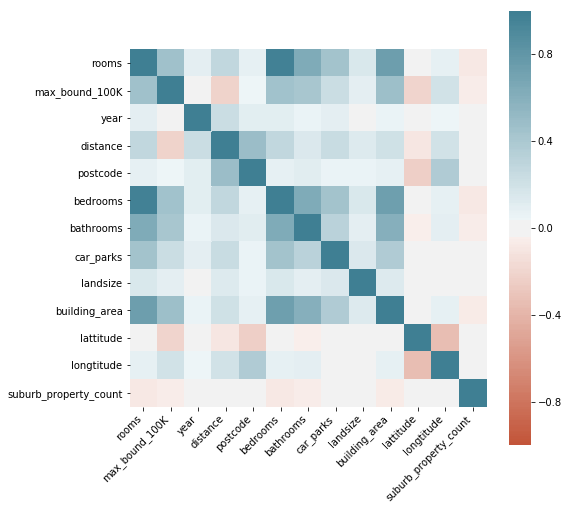

In [36]:
## correlation matrix
corr = data_copy.corr()
plt.figure(figsize = (8,8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
# data_copy.dtypes
# data_copy.head()
data_copy.corr()

In [37]:
test_data = data_copy.drop(columns=['max_bound_100K'])

## seperate target and attributes
X = test_data.drop(columns='price_bands')
Y = test_data['price_bands']

# le_suburb = preprocessing.LabelEncoder()
# suburb = data_copy['suburb']
# le_suburb.fit(suburb)
# suburb_converted = le_suburb.transform(suburb)

# data_copy['suburb'] = suburb_converted

## encode attributes
X_converted = pd.get_dummies(X)

X_converted.shape

## encode target
le = preprocessing.LabelEncoder()
le.fit(Y)

Y_converted = le.transform(Y)
max_value = max(Y_converted)
print(max_value)
class_labels = le.inverse_transform(np.arange(max_value + 1))

print(Y_converted)
print(class_labels)

## split train and test data
train_x, test_x, train_y, test_y = train_test_split(np.array(X_converted), np.array(Y_converted), test_size=0.2, random_state=41)

# clf = tree.DecisionTreeClassifier(min_samples_split=12)
clf = RandomForestClassifier(n_estimators=30, min_samples_split=12, random_state=42)
clf.fit(train_x, train_y)
predictions = clf.predict(test_x)
print("accuracy: ")
print(metrics.accuracy_score(test_y, predictions))

feature_imp = pd.Series(clf.feature_importances_, index=X_converted.columns).sort_values(ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(feature_imp)

72
[ 0  2  2 ... 69 71  4]
[u'0K-100K' u'1000K-1100K' u'100K-200K' u'1100K-1200K' u'11200K-11300K'
 u'1200K-1300K' u'1300K-1400K' u'1400K-1500K' u'1500K-1600K'
 u'1600K-1700K' u'1700K-1800K' u'1800K-1900K' u'1900K-2000K'
 u'2000K-2100K' u'200K-300K' u'2100K-2200K' u'2200K-2300K' u'2300K-2400K'
 u'2400K-2500K' u'2500K-2600K' u'2600K-2700K' u'2700K-2800K'
 u'2800K-2900K' u'2900K-3000K' u'3000K-3100K' u'300K-400K' u'3100K-3200K'
 u'3200K-3300K' u'3300K-3400K' u'3400K-3500K' u'3500K-3600K'
 u'3600K-3700K' u'3700K-3800K' u'3800K-3900K' u'3900K-4000K'
 u'4000K-4100K' u'400K-500K' u'4100K-4200K' u'4200K-4300K' u'4300K-4400K'
 u'4400K-4500K' u'4500K-4600K' u'4600K-4700K' u'4700K-4800K'
 u'4800K-4900K' u'4900K-5000K' u'5000K-5100K' u'500K-600K' u'5100K-5200K'
 u'5200K-5300K' u'5300K-5400K' u'5400K-5500K' u'5500K-5600K'
 u'5600K-5700K' u'5700K-5800K' u'5800K-5900K' u'5900K-6000K'
 u'6000K-6100K' u'600K-700K' u'6100K-6200K' u'6200K-6300K' u'6300K-6400K'
 u'6400K-6500K' u'6500K-6600K' u'6600K-6700

In [38]:
data_copy.isnull().values.any()

False

In [39]:
data_copy.to_csv('cleaned_data.csv', index=False)